### Sensitivity analysis

The sensitivity analysis is carried out in this notebook. An extra note of caution is that this notebook also runs completely parallel using pool.starmap(). This uses up all the resources available on the system. Hence, don't be afraid when your laptop flies to the moon or freezes. 

In [1]:
%matplotlib inline
import time
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy import io
import pickle

# Own code
sys.path.append("../")
from utils.data_utils import generate_contemp_matrices, transformation, standardize
from utils.tvp_models import TVPVARModel, tvp_ar_contemp_decomposition

# Suppress scientific notation in numpy
np.set_printoptions(suppress=False)

In [2]:
# Set M and standardization

M = 3
standardization = False
transform = True

In [3]:
ds = pd.read_csv("../data/fred_qd.csv")
gdp = transformation(ds["GDPC1"].iloc[2:].to_numpy(), 5, transform, scale=1)
cpi = transformation(ds["CPIAUCSL"].iloc[2:].to_numpy(), 6, transform, scale=1)
fedfund = transformation(ds["FEDFUNDS"].iloc[2:].to_numpy(), 2, transform, scale=1)
compi = transformation(ds["PPIACO"].iloc[2:].to_numpy(), 6, transform, scale=1)
borrowings = transformation(ds["TOTRESNS"].iloc[2:].to_numpy(), 6, transform, scale=1)
sp500 = transformation(ds["S&P 500"].iloc[2:].to_numpy(), 5, transform, scale=1)
m2 = transformation(ds["M2REAL"].iloc[2:].to_numpy(), 5, transform, scale=1)

# Start due to transformation

lag = 1

if M == 3:

    series = [gdp[lag:], cpi[lag:], fedfund[lag:]]
    
elif M == 7:
    
    series = [gdp[lag:], cpi[lag:], fedfund[lag:],compi[lag:],borrowings[lag:],sp500[lag:],m2[lag:]]
    

if standardization:
    
    series = standardize(series, train = 243-25)

series_total = np.array(series)

y_matrix_contemp, X_matrix_contemp = generate_contemp_matrices(244, M, 1, series_total)

# Lasso 

In [ ]:
# Check if the model, given the specific data, converges at all

T = 243
p = 1
prior = "lasso_alternative"
train = T - 25

model = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=100)
msfe, *_, msfe_complete, alpl_complete = model.result()

### Parameter -> $a_{0}$

In [5]:
def calculate_derivative_lasso_a0(iteration, parameter_value):
    
    prior = "lasso_alternative"
    T = 243
    p = 1
    train = T-25
    iterations = 100

    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0_lasso":parameter_value+error,"b0_lasso":1e-3}
    prior_parameters_minus = {"a0_lasso":parameter_value-error,"b0_lasso":1e-3}
    
    model_plus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_plus, *_, msfe_complete_plus, alpl_complete_plus = model_plus.result()
    
    model_minus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    msfe_minus, *_, msfe_complete_minus, alpl_complete_minus = model_minus.result()
       
    msfe_complete_plus_reshaped = msfe_complete_plus.reshape(8,M,25).mean(2).mean(0)
    msfe_complete_minus_reshaped = msfe_complete_minus.reshape(8,M,25).mean(2).mean(0)
        
    derivative_complete = (msfe_complete_plus_reshaped - msfe_complete_minus_reshaped)/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [6]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-3
finish = 2
interval = 64

a0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_lasso_a0, a0_set)

Run: 6 -> Derivative: [-8.94810720e-08  4.96198181e-09  9.85780386e-08]
Run: 11 -> Derivative: [-8.51806878e-08  5.62357939e-09  9.69240447e-08]
Run: 7 -> Derivative: [-8.88194744e-08  5.29278060e-09  9.79164411e-08]
Run: 4 -> Derivative: [-9.17966635e-08  4.96198181e-09  9.95704350e-08]
Run: 5 -> Derivative: [-9.04734684e-08  4.96198181e-09  9.92396362e-08]
Run: 2 -> Derivative: [-9.37814562e-08  4.79658242e-09  9.99012338e-08]
Run: 15 -> Derivative: [-8.20380993e-08  6.28517696e-09  9.65932459e-08]
Run: 3 -> Derivative: [-9.27890599e-08  4.96198181e-09  1.00232033e-07]
Run: 9 -> Derivative: [-8.68346817e-08  5.29278060e-09  9.82472399e-08]
Run: 14 -> Derivative: [-8.28650962e-08  5.78897878e-09  9.56008496e-08]
Run: 12 -> Derivative: [-8.41882914e-08  5.95437817e-09  9.75856423e-08]
Run: 8 -> Derivative: [-8.76616787e-08  5.29278060e-09  9.75856423e-08]
Run: 13 -> Derivative: [-8.36920932e-08  6.28517696e-09  9.49392520e-08]
Run: 1 -> Derivative: [-9.46084532e-08  5.12738120e-09  1.0

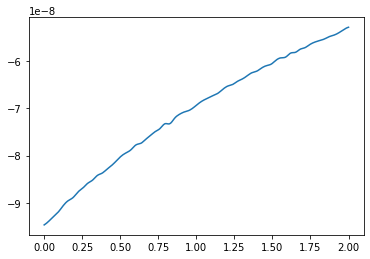

In [15]:
from scipy.interpolate import make_interp_spline, BSpline

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), interval*4) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [8]:
prior = "lasso_alternative"
parameter = "a0_lasso"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_M_huber.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $b_{0}$

In [ ]:
def calculate_derivative_lasso_b0(iteration, parameter_value):
    
    prior = "lasso_alternative"
    T = 243
    p = 1
    train = T-25
    iterations = 75
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0_lasso":1e-3,"b0_lasso":parameter_value+error}
    prior_parameters_minus = {"a0_lasso":1e-3,"b0_lasso":parameter_value-error}
        
    model_plus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_plus, *_, msfe_complete_plus, alpl_complete_plus = model_plus.result()
    
    model_minus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    msfe_minus, *_, msfe_complete_minus, alpl_complete_minus = model_minus.result()

    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-3
finish = 1
interval = 256

b0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_lasso_b0, b0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), interval*4) 

spl = make_interp_spline(result[:,0], result[:,3], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "lasso_alternative"
parameter = "b0_lasso"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_vb_based_huber.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

# SVSS

In [ ]:
# Check if the model, given the specific data, converges at all

T = 243
p = 1
prior = "svss"

train = T - 25

prior_parameters = {"g0":1,"h0":12,"pi0":0.5}

model = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=100, prior_parameters=prior_parameters)
msfe, *_  = model.result()

# msfe, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=75, prior_parameters=prior_paramters)

### Parameter -> $g_{0}$

In [ ]:
def calculate_derivative_svss_g0(iteration, parameter_value):
    
    prior = "svss"
    T = 243
    p = 1
    train = T-25
    iterations = 75
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"g0":parameter_value+error,"h0":1e-2, "pi0":0.5}
    prior_parameters_minus = {"g0":parameter_value-error,"h0":1e-2, "pi0":0.5}
    
    model_plus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_plus, *_, msfe_complete_plus, alpl_complete_plus = model_plus.result()
    
    model_minus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    msfe_minus, *_, msfe_complete_minus, alpl_complete_minus = model_minus.result()
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1
finish = 1.5
interval = 64

g0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_svss_g0, g0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), interval*4) 

spl = make_interp_spline(result[:,0], result[:,75], k=3)  # type: BSpline+
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "svss"
parameter = "g0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_std_huber.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $h_{0}$

In [ ]:
def calculate_derivative_svss_h0(iteration, parameter_value):
    
    prior = "svss"
    T = 243
    p = 1
    train = T-25
    iterations = 75
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"g0":1,"h0":parameter_value+error, "pi0":0.5}
    prior_parameters_minus = {"g0":1,"h0":parameter_value-error, "pi0":0.5}
    
    model_plus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_plus, *_, msfe_complete_plus, alpl_complete_plus = model_plus.result()
    
    model_minus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    msfe_minus, *_, msfe_complete_minus, alpl_complete_minus = model_minus.result()
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 12
finish = 14
interval = 128

h0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_svss_h0, h0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), interval*4)

spl = make_interp_spline(result[:,0], result[:,75], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "svss"
parameter = "h0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_huber.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

# Horseshoe

In [ ]:
# Check if the model, given the specific data, converges at all

T = 243
p = 1
prior = "horseshoe"
train = T - 25

prior_parameters = {"a0":5, "b0":1}

msfe, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=100, prior_parameters=prior_parameters)

### Parameter -> $a_{0}$

In [ ]:
def calculate_derivative_horseshoe_a0(iteration, parameter_value):
    
    prior = "horseshoe"
    T = 243
    p = 1
    train = T-25
    iterations = 150
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0":parameter_value+error,"b0":1}
    prior_parameters_minus = {"a0":parameter_value-error,"b0":1}
    
    model_plus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_plus, *_, msfe_complete_plus, alpl_complete_plus = model_plus.result()
    
    model_minus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    msfe_minus, *_, msfe_complete_minus, alpl_complete_minus = model_minus.result()
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 4
finish = 5
interval = 256

a0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_horseshoe_a0, a0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), interval*4) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "horseshoe"
parameter = "a0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_vb_based_huber.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $b_{0}$

In [ ]:
def calculate_derivative_horseshoe_b0(iteration, parameter_value):
    
    prior = "horseshoe"
    T = 243
    p = 1
    train = T-25
    iterations = 100
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0":4,"b0":parameter_value+error}
    prior_parameters_minus = {"a0":4,"b0":parameter_value-error}
    
    model_plus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_plus, *_, msfe_complete_plus, alpl_complete_plus = model_plus.result()
    
    model_minus = tvp_ar_contemp_decomposition(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    msfe_minus, *_, msfe_complete_minus, alpl_complete_minus = model_minus.result()
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1
finish = 1.5
interval = 256

b0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_horseshoe_b0, b0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), interval*4) 

spl = make_interp_spline(result[:,0], result[:,7], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "horseshoe"
parameter = "b0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_vb_based_huber.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)